# Script to reconstruct information from 4D-data collected from Experiment

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from skimage import feature
from pylab import *

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


In [2]:
ExpPath = '/srv/home/chenyu/DEbackup/081619/S1/'
RefPath = '/srv/home/chenyu/DEbackup/081619/S0/'
ExpName = 'S1'
RefName = 'S0'
rx = 150;
ry = 150;

## Analysis background COM from blank scan

### Example of COM detection

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


254.8652808574908 260.13477471402854


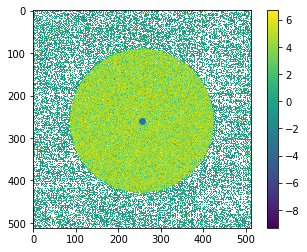

In [3]:
sample = np.load(RefPath+'npy/'+RefName+'_'+format(10000,'05')+'.npy')
kx,ky = sample.shape[0:2]
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)

COM_x = np.average(weights_x,weights = sample)
COM_y = np.average(weights_y,weights = sample)
           
plt.imshow(log(sample))
plt.colorbar()
plt.scatter(COM_x,COM_y)
print(COM_x,COM_y)

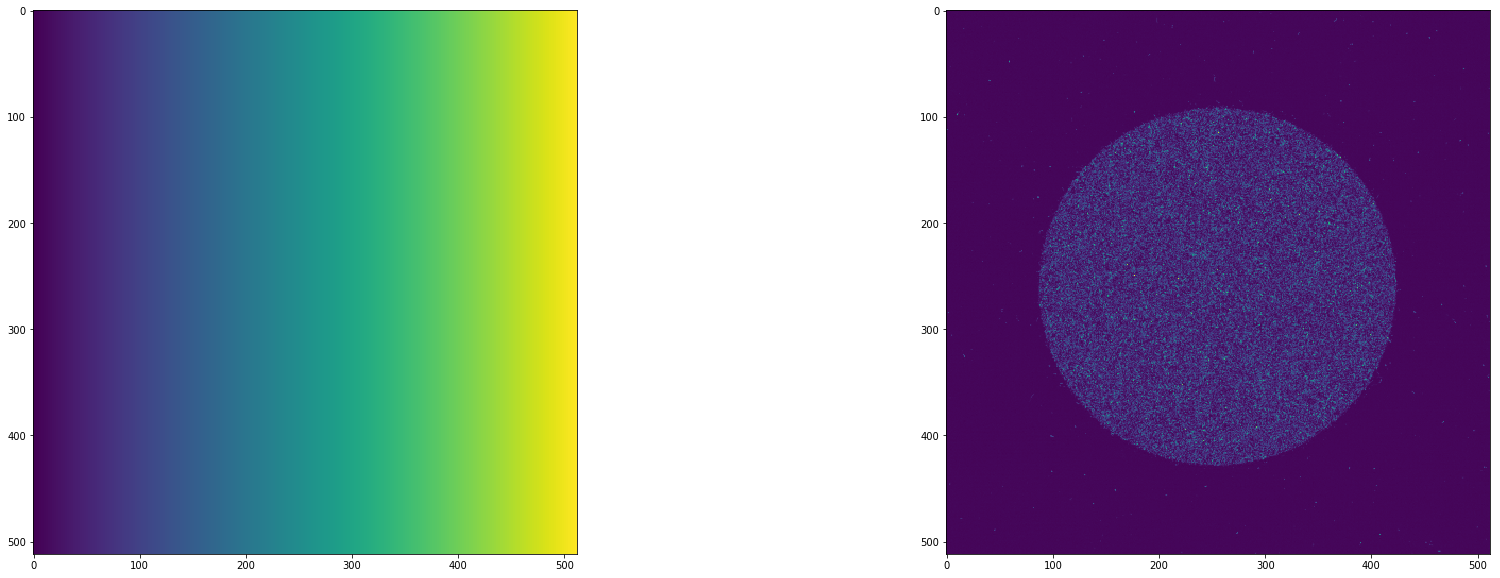

In [4]:
fig = plt.figure(figsize=(30,10))
fig.add_subplot(121)
plt.imshow(weights_x)
fig.add_subplot(122)
plt.imshow(sample)

In [2]:
RefPath = '/srv/home/chenyu/DEbackup/091819/S0/'
# RefPath2 = '/srv/home/chenyu/DEbackup/041119/C2/'
# RefPath3 = '/srv/home/chenyu/DEbackup/041119/C3/'
RefName = 'S0'
# number of rows and columns for the scan grid
num_rows = 200
num_cols = 200

sample = np.load(RefPath+'npy/'+RefName+'_'+format(1,'05')+'.npy')
kx,ky = sample.shape[0:2]
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)

COM = np.zeros((num_rows,num_cols,2))

for irow in range(num_rows):
    for icol in range(num_cols):
        nSample = irow*num_cols+icol+1
        sample = np.load(RefPath+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
#         sample = sample + np.load(RefPath2+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
#         sample = sample + np.load(RefPath3+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        COM[irow,icol,0] = np.average(weights_x,weights = sample)
        COM[irow,icol,1] = np.average(weights_y,weights = sample)
        
        if irow % 10 == 0 and icol == 0:
            print("Finished row %d " % (irow))
            
np.save('/srv/home/chenyu/DEbackup/091819/BlankCOM.npy',COM)

Finished row 0 
Finished row 10 
Finished row 20 
Finished row 30 
Finished row 40 
Finished row 50 
Finished row 60 
Finished row 70 
Finished row 80 
Finished row 90 
Finished row 100 
Finished row 110 
Finished row 120 
Finished row 130 
Finished row 140 
Finished row 150 
Finished row 160 
Finished row 170 
Finished row 180 
Finished row 190 


In [7]:
print(np.mean(COM[:,:,0]))
print(np.mean(COM[:,:,1]))

255.44703223171408
260.0287448488333


In [6]:
sample = np.load(RefPath2+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
sample = sample + np.load(RefPath3+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
COM[ix,iy,0] = np.average(weights_x,weights = sample)
COM[ix,iy,1] = np.average(weights_y,weights = sample)

255.4537414673932
260.02962190212287


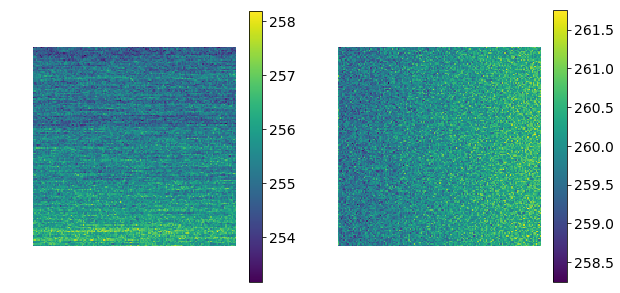

In [8]:
COM = np.load('/srv/home/chenyu/DEbackup/081619/BlankCOM.npy')

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.imshow(COM[2:-1,:,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

fig.add_subplot(122)
plt.imshow(COM[2:-1:,:,1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

print(COM[2:-1,:,0].mean())
print(COM[2:-1,:,1].mean())

In [9]:
np.save('/srv/home/chenyu/DEbackup/021019/BlankCOM.npy',COM)

### Example of position center detection using Gaussian fit

254.95186183153788 290.98164424959907


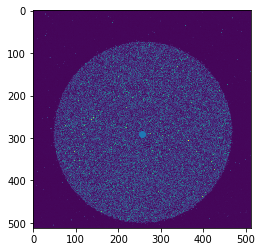

In [73]:
kx = 512
ky = 512
kx2,ky2 = np.meshgrid(np.linspace(0,kx-1,kx), np.linspace(0,ky-1,ky))
distance_from_center = np.sqrt((kx2 - 256)**2 + (ky2-256)**2)
mask = distance_from_center <= 212
mask = mask* distance_from_center
mask_FT = np.fft.fft2(mask)

frame = sample
frame = frame/frame.max()
frame = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(frame) * mask_FT)).real
frame_crop = frame[int(COM_y)-50:int(COM_y)+50,int(COM_x)-50:int(COM_x)+50]
params = fitgaussian(frame_crop)
plt.imshow(sample)
plt.scatter(params[1]+COM_x-50,params[2]+COM_y-50)
print(params[1]+COM_x-50,params[2]+COM_y-50)

### Analysis zerodisk shift in blank scan using 2D Gaussian fit following convolution with round mask

In [12]:
def gaussian(height, center_x, center_y, width_x, width_y):

    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)
 
def moments(data):

    total = data.sum()
    X, Y = indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = sqrt(abs((arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = sqrt(abs((arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y
 
def fitgaussian(data):

    params = moments(data)
    errorfunction = lambda p: ravel(gaussian(*p)(*indices(data.shape)) -
                                  data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [97]:
kx = 512
ky = 512
kx2,ky2 = np.meshgrid(np.linspace(0,kx-1,kx), np.linspace(0,ky-1,ky))
distance_from_center = np.sqrt((kx2 - 256)**2 + (ky2-256)**2)
mask = distance_from_center <= 212
mask = mask* distance_from_center
mask_FT = np.fft.fft2(mask)
pos = np.zeros((rx,ry,2))

COM = np.load('/srv/home/chenyu/DEbackup/110818/T3/BlankCOM.npy')

for ix in range(rx):
    for iy in range(ry):
        COM_x = COM[ix,iy,0]
        COM_y = COM[ix,iy,1]
        filenum = ix*rx+iy+1
        frame = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        frame = frame/frame.max()
        frame = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(frame) * mask_FT)).real
        frame_crop = frame[int(COM_y)-50:int(COM_y)+50,int(COM_x)-50:int(COM_x)+50]
        params = fitgaussian(frame_crop)
        
#         print(params[1],params[2])
        
        pos[ix,iy,0] = params[1]+COM_x-50 # xpos
        pos[ix,iy,1] = params[2]+COM_y-50 # ypos
        
        if ix % 10 == 0 and iy == 0:
            print("Finished line %d " % (ix))

Finished line 0 
Finished line 10 
Finished line 20 
Finished line 30 
Finished line 40 
Finished line 50 
Finished line 60 
Finished line 70 
Finished line 80 
Finished line 90 
Finished line 100 
Finished line 110 
Finished line 120 
Finished line 130 
Finished line 140 


In [98]:
np.save('/srv/home/chenyu/DEbackup/110818/T3/BlankCOMpos.npy',pos)

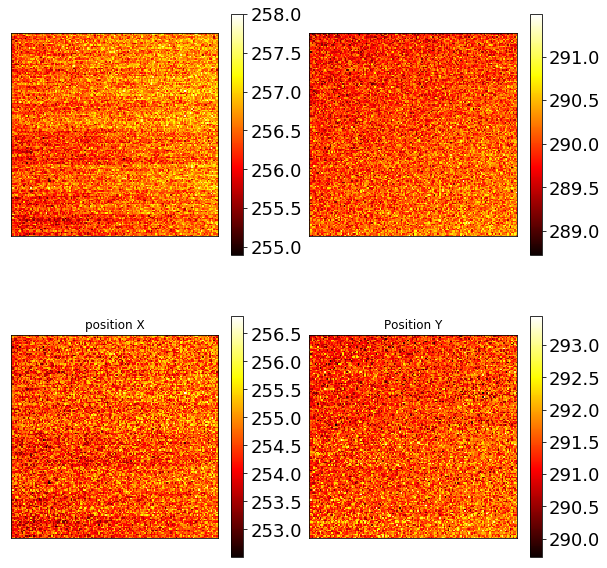

In [123]:
COM = np.load('/srv/home/chenyu/DEbackup/110818/T1/BlankCOM.npy')
pos = np.load('/srv/home/chenyu/DEbackup/110818/T1/BlankCOMpos.npy')


f, axarr = plt.subplots(2, 2, gridspec_kw = {'wspace':0.15, 'hspace':0.25}, figsize=(10,10))

im = axarr[0,0].imshow(COM[2:-1,:,0],cmap='hot')
axarr[0,0].set_xticks([])
axarr[0,0].set_yticks([])
cbar=f.colorbar(im,ax=axarr[0,0])
cbar.ax.tick_params(labelsize=18)

im = axarr[0,1].imshow(COM[2:-1,:,1],cmap='hot')
axarr[0,1].set_xticks([])
axarr[0,1].set_yticks([])
cbar = f.colorbar(im, ax=axarr[0,1])
cbar.ax.tick_params(labelsize=18) 

# Seems X and Y are reversed in position fitting

im = axarr[1,0].imshow(pos[2:-1,:,0],cmap='hot')
axarr[1,0].set_xticks([])
axarr[1,0].set_yticks([])
axarr[1,0].set_title('position X')
cbar = f.colorbar(im, ax=axarr[1,0])
cbar.ax.tick_params(labelsize=18) 

im = axarr[1,1].imshow(pos[2:-1,:,1],cmap='hot')
axarr[1,1].set_xticks([])
axarr[1,1].set_yticks([])
axarr[1,1].set_title('Position Y')
cbar = f.colorbar(im, ax=axarr[1,1])
cbar.ax.tick_params(labelsize=18) 


### Analysis zerodisk shift in blank scan using Hough transform

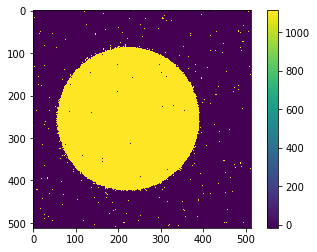

In [12]:
sample = np.load(RefPath+'npy/'+RefName+'_'+format(2500,'05')+'.npy')
plt.imshow(sample)
plt.colorbar()
bw = 1.0*(sample > 20)
plt.imshow(bw)
selem = disk(3)
bw2 = closing(bw, selem)
plt.imshow(bw2)
edges = feature.canny(bw2)
plt.imshow(bw)

In [13]:
plt.imshow(temp)

NameError: name 'temp' is not defined

None


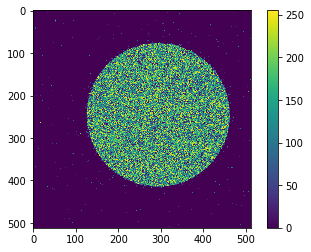

In [18]:
sample = sample*bw
sample = sample.astype('uint8')
temp = edges.astype('uint8')
plt.imshow(sample)
plt.colorbar()

output = temp.copy()

circles = cv2.HoughCircles(temp, cv2.HOUGH_GRADIENT, 1,20,param1=50,param2=30,minRadius=100,maxRadius=200)
print(circles)


# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")

#     # loop over the (x, y) coordinates and radius of the circles
#     for (x, y, r) in circles:
#         # draw the circle in the output image, then draw a rectangle
#         # corresponding to the center of the circle
#         cv2.circle(output, (x, y), r, (0, 255, 0), 4)
#         cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

#     # show the output image
#     cv2.imshow("output", np.hstack([temp, output]))
# #     cv2.waitKey(0)

[262 263 263 260 261] [292 291 293 293 290] [168 167 169 166 169]
261 291 167


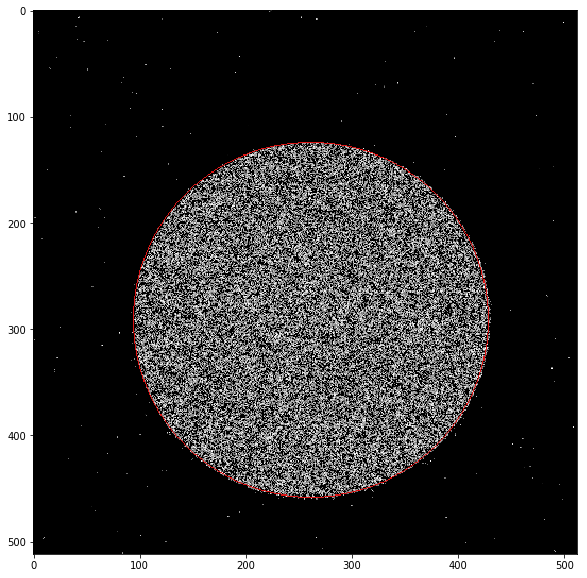

261 291 167


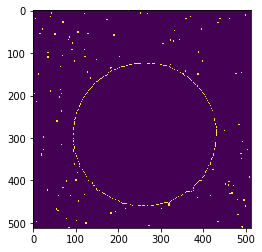

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

# RefPath = '/srv/home/chenyu/DEbackup/012119/C1/'
# RefPath2 = '/srv/home/chenyu/DEbackup/012119/C2/'
# RefPath3 = '/srv/home/chenyu/DEbackup/012119/C3/'
# RefName = 'S0'
# rx = 150
# ry = 150

# irow = 8
# icol = 75
# nSample = irow*150+icol+1

# sample = np.load(RefPath+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
# sample = sample + np.load(RefPath2+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
# sample = sample + np.load(RefPath3+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
# # plt.imshow(sample)
# plt.colorbar()
bw = 1.0*(sample > 100)
selem = disk(5)
bw2 = closing(bw, selem)
edges = feature.canny(bw2)

sample = sample*bw
sample = sample.astype('uint8')
temp = edges.astype('uint8')
# plt.imshow(sample)
# plt.colorbar()

image = sample

# Detect two radii
hough_radii = np.arange(175,190,1)
hough_radii = np.arange(165,175,1)
hough_res = hough_circle(temp, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=5)

print(cx,cy,radii)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
image = color.gray2rgb(image)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)
circy, circx = circle_perimeter(cy,cx,radii)
# circy, circx = circle_perimeter(290,262,181)
image[circy, circx] = (220, 20, 20)

# for center_y, center_x, radius in zip(cy, cx, radii):
#     circy, circx = circle_perimeter(center_y, center_x, radius)
#     image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()
plt.imshow(temp)
print(cx,cy,radii)

[164 163 165] [164 164 165] [47 48 46]
164 164 47


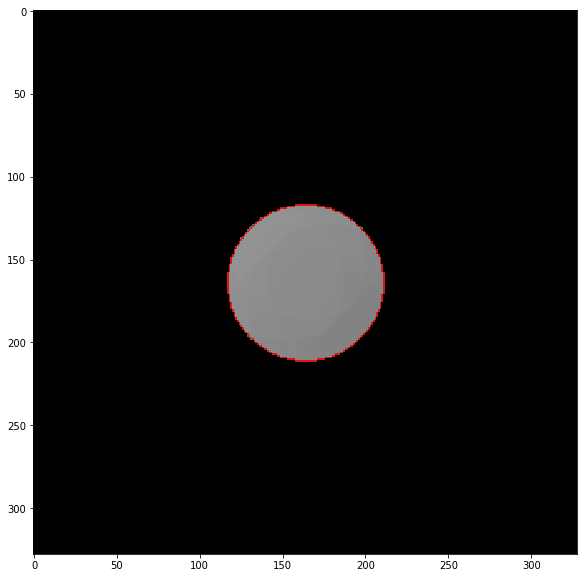

164 164 47


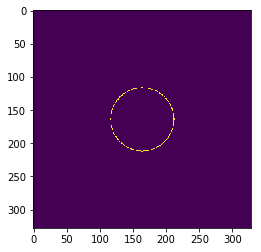

In [15]:
# sample = np.load('/srv/home/chenyu/antisite/PRISMATIC/Depth0_larger/depth0_slice0_90pmss.npy')
# sample = sample[1,1,:,:]

bw = 1.0*(sample > 0.0001)
selem = disk(5)
bw2 = closing(bw, selem)
edges = feature.canny(bw2)

sample = sample*bw*1000000
sample = sample.astype('uint8')
temp = edges.astype('uint8')
# plt.imshow(sample)
# plt.colorbar()

image = sample

# Detect two radii
hough_radii = np.arange(45,55,1)
hough_res = hough_circle(temp, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

print(cx,cy,radii)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
image = color.gray2rgb(image)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)
circy, circx = circle_perimeter(cy,cx,radii)
# circy, circx = circle_perimeter(290,262,181)
image[circy, circx] = (220, 20, 20)

# for center_y, center_x, radius in zip(cy, cx, radii):
#     circy, circx = circle_perimeter(center_y, center_x, radius)
#     image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()
plt.imshow(temp)
print(cx,cy,radii)

In [24]:
pos_Hough_avg = np.zeros((rx,ry,2))
for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        sample = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        sample = sample + np.load(RefPath2+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        sample = sample + np.load(RefPath3+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        
        bw = 1.0*(sample > 100)
        selem = disk(5)
        bw2 = closing(bw, selem)
        edges = feature.canny(bw2)

        sample = sample*bw
        sample = sample.astype('uint8')
        temp = edges.astype('uint8')
        
        hough_radii = np.arange(175,190,1)
        hough_res = hough_circle(temp, hough_radii)

        # Select the most prominent 5 circles
        accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                                   total_num_peaks=5)
        if cx is not None:
            pos_Hough_avg[ix,iy,0] = np.average(cx)
            pos_Hough_avg[ix,iy,1] = np.average(cy)
#             if pos_Hough_avg[ix,iy,0] > 260:
#                 print(ix,iy)
#             print(cx,cy)
        else:
            pos_Hough_avg[ix,iy,0] = 0
            pos_Hough_avg[ix,iy,0] = 0
        
        if ix % 10 == 0 and iy == 0:
            print("Finished line %d " % (ix))

np.save('/srv/home/chenyu/DEbackup/112518/BlankPOS_hough.npy',pos_Hough_avg)

Finished line 0 


KeyboardInterrupt: 

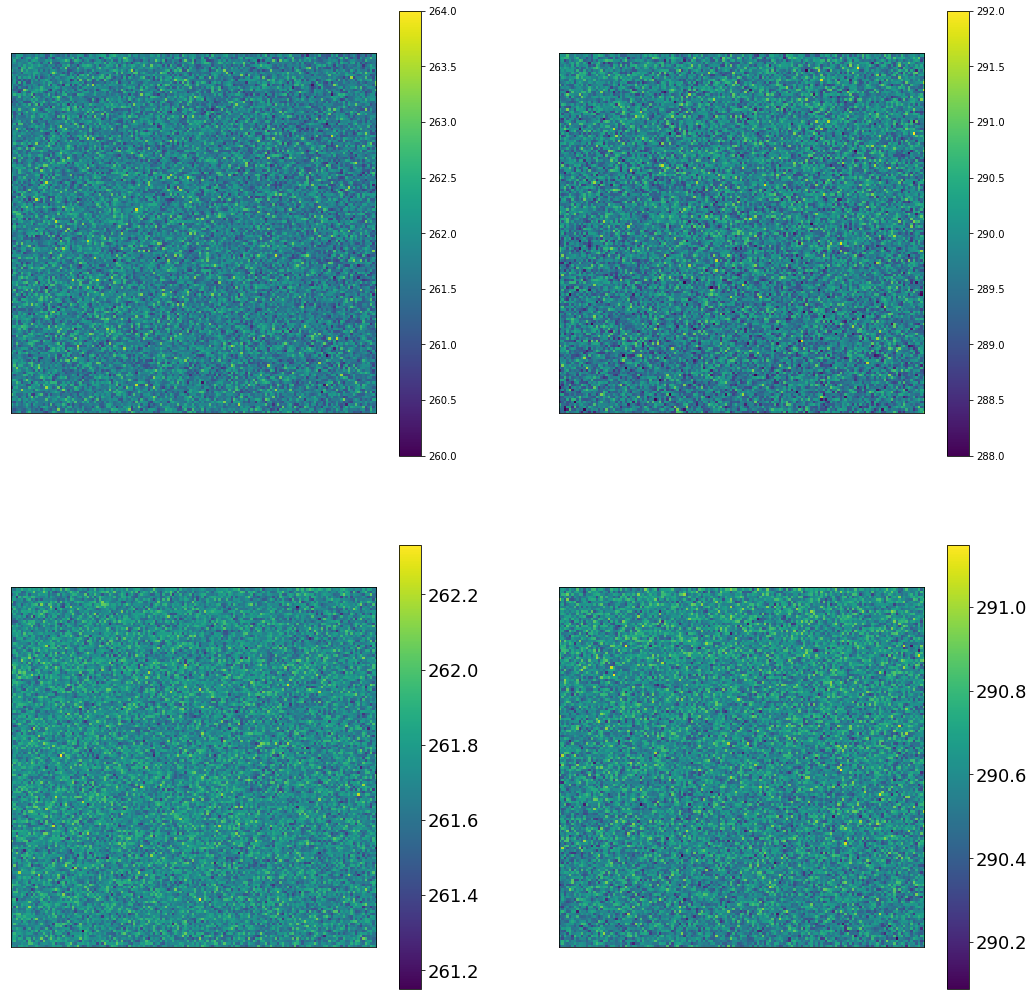

In [93]:
pos_Hough_avg = np.load('/srv/home/chenyu/DEbackup/112518/BlankPOS_hough.npy')
fig, ax = plt.subplots(2,2,figsize=(18, 18))
im0 = ax[0,0].imshow(pos_Hough_avg[1:-1,:,0],clim=[260,264])
im1 = ax[0,1].imshow(pos_Hough_avg[1:-1,:,1],clim=[288,292])
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
cbar = fig.colorbar(im0,ax=ax[0,0])
cbar = fig.colorbar(im1,ax=ax[0,1])


im2 = ax[1,0].imshow(COM_zerodisk[1:-1,:,0])
im3 = ax[1,1].imshow(COM_zerodisk[1:-1,:,1])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
cbar = fig.colorbar(im2,ax=ax[1,0])
cbar.ax.tick_params(labelsize=18) 
cbar = fig.colorbar(im3,ax=ax[1,1])
cbar.ax.tick_params(labelsize=18) 
# pos_Hough_avg[:,:,1]


### Analysis COM shift within zero disk

In [87]:
kx = 512
ky = 512
kx2,ky2 = np.meshgrid(np.linspace(0,kx-1,kx), np.linspace(0,ky-1,ky))


kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)



COM_zerodisk = np.zeros((150,150,2))

for ix in range(150):
    if ix % 10 is 0:
        print('Now working on row ' + str(ix))
    for iy in range(150):

        nSample = ix*rx+iy+1

        sample = np.load(RefPath+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        sample = sample + np.load(RefPath2+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        sample = sample + np.load(RefPath3+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        
        cx = 262
        cy = 290
        distance_from_center = np.sqrt((kx2 - cx)**2 + (ky2-cy)**2)
        mask = (distance_from_center <= 175) 
        
        COM_zerodisk[ix,iy,0] = np.average(weights_x,weights = sample*mask)
        COM_zerodisk[ix,iy,1] = np.average(weights_y,weights = sample*mask)


Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90
Now working on row 100
Now working on row 110
Now working on row 120
Now working on row 130
Now working on row 140


(-0.5, 149.5, 146.5, -0.5)

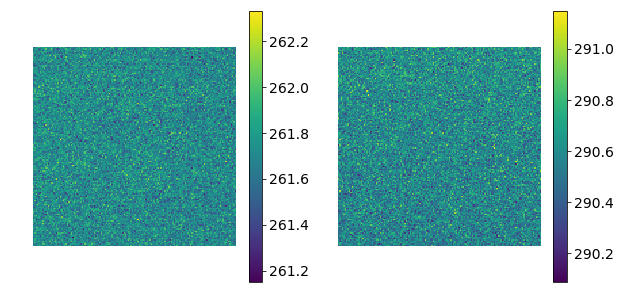

In [88]:
# COM_zerodisk = np.load('/srv/home/chenyu/DEbackup/112518/BlankCOM_170px.npy')

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.imshow(COM_zerodisk[2:-1,:,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

fig.add_subplot(122)
plt.imshow(COM_zerodisk[2:-1:,:,1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

In [41]:
np.save('/srv/home/chenyu/DEbackup/112518/BlankCOM_175-179px.npy',COM_zerodisk)

## BF, ABF, COM, PACBED reconstruction from experiment dataset

In [3]:
# load previous reconstucted blank COM map if it exist
ExpPath = '/srv/home/chenyu/DEbackup/061219/S8/'
ExpName = 'S8'
rx = 150
ry = 150
COM = np.load('/srv/home/chenyu/DEbackup/061219/BlankCOM.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/srv/home/chenyu/DEbackup/061219/BlankCOM.npy'

In [4]:
sample = np.load(ExpPath+'npy/'+ExpName+'_'+format(1000,'05')+'.npy')
kx,ky = sample.shape[0:2]
PACBED = np.zeros((kx,ky))

kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
kx2,ky2 = np.meshgrid(kx,ky)

COM_exp = np.zeros((rx,ry,2))
COM_exp_ang = np.zeros((rx,ry))
BF = np.zeros((rx,ry))
ABF = np.zeros((rx,ry))
ADF = np.zeros((rx,ry))

# inner collection radius for ABF and outer collection radius for BF/ABF, replace with Hough detected radius later
ABF_radius = 106
BF_radius = 212
ADF_radius = 276

for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(ExpPath+'npy/'+ExpName+'_'+format(filenum,'05')+'.npy')
        COM_exp[ix,iy,0] = np.average(weights_x,weights = frame)
        COM_exp[ix,iy,1] = np.average(weights_y,weights = frame)
        COM_exp_ang[ix,iy] = math.atan2(COM_exp[ix,iy,0]-COM[ix,iy,0],COM_exp[ix,iy,1]-COM[ix,iy,1])
        
        center_x = COM[ix,iy,0]
        center_y = COM[ix,iy,1]
        distance_from_center = np.sqrt((kx2 - center_x)**2 + (ky2-center_y)**2)
        ADF_mask = (distance_from_center > BF_radius) & (distance_from_center <= ADF_radius)
        ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
        BF_mask = distance_from_center <= BF_radius
        
        BF[ix,iy] = (frame*BF_mask).sum()
        ABF[ix,iy] = (frame*ABF_mask).sum()
        ADF[ix,iy] = (frame*ADF_mask).sum()
        PACBED = PACBED + frame
        
COM_exp = COM_exp - COM
COM_exp_mag = np.sqrt(COM_exp[:,:,0]**2 + COM_exp[:,:,1]**2)

np.save(ExpPath + 'ADF.npy',ADF)
# np.save(ExpPath+'COM.npy',COM_exp)
# np.save(ExpPath+'BF.npy',BF)
# np.save(ExpPath+'ABF.npy',ABF)
# np.save(ExpPath+'PACBED.npy',PACBED)

In [19]:
math.atan2(COM_x_proj,COM_y_proj)

TypeError: only size-1 arrays can be converted to Python scalars

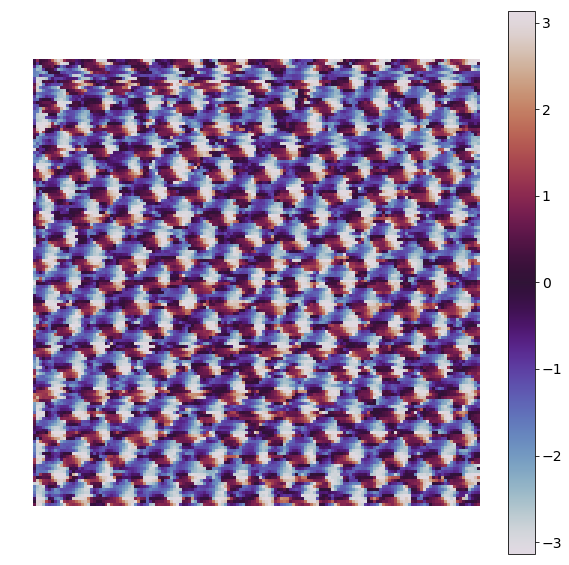

In [68]:
# ABF_radius = 106
# BF_radius = 212
# ADF_radius = 270
# ADF_mask = (distance_from_center > BF_radius) & (distance_from_center <= ADF_radius)
# plt.imshow(ADF_mask)

# Project COM along two axis, then calculate angle
rot = 160+180 # rotation in degrees, counter-clockwise as positive, following python setting
rot = math.radians(rot)
COM_x_proj = COM_exp[:,:,0]*cos(rot)-COM_exp[:,:,1]*sin(rot)
COM_y_proj = COM_exp[:,:,1]*cos(rot)+COM_exp[:,:,0]*sin(rot)
for ix in range(rx):
    for iy in range(ry):
        COM_exp_ang[ix,iy] = math.atan2(COM_y_proj[ix,iy],COM_x_proj[ix,iy])

fig = plt.figure(figsize=(10,10))
plt.imshow(COM_exp_ang, cmap='twilight')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
fig.savefig('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/COM_angle_projected.tiff')
# plt.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/COM_angle.tiff',COM_exp_ang,cmap='twilight')

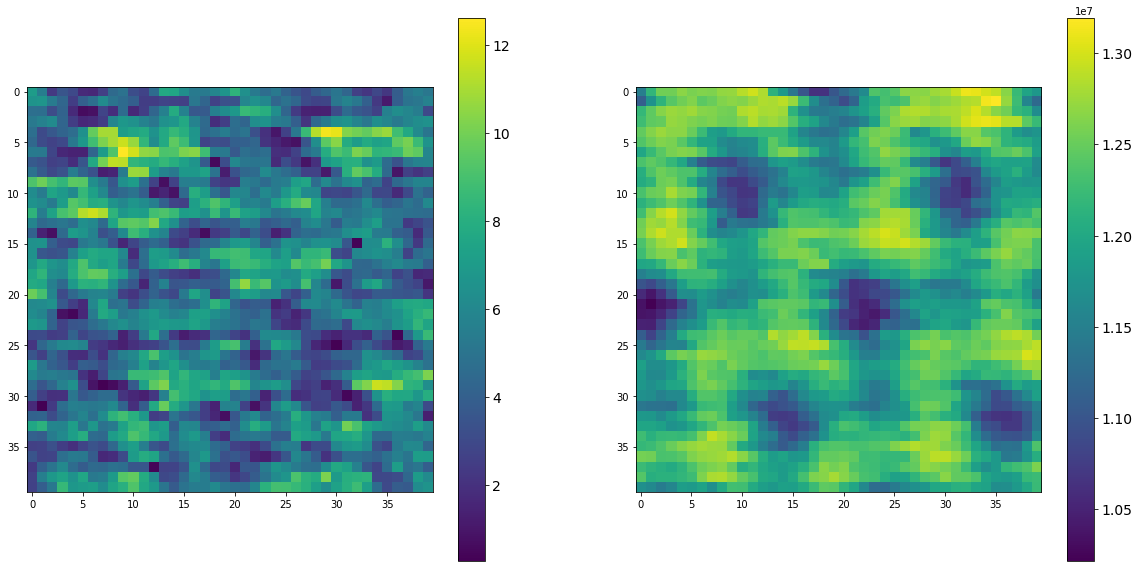

In [18]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1)
plt.imshow(COM_exp_mag[20:60,20:60])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

fig.add_subplot(1,2,2)
plt.imshow(ABF[20:60,20:60])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

Text(0.5,1,'COM magnitute')

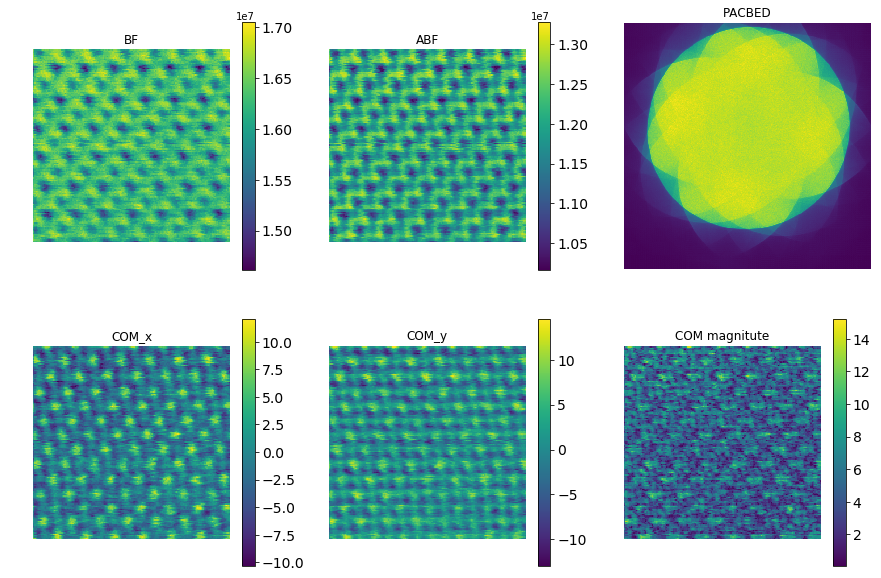

In [15]:
fig = plt.figure(figsize=(15,10))

fig.add_subplot(2,3,1)
plt.imshow(BF[2:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('BF')

fig.add_subplot(2,3,2)
plt.imshow(ABF[2:-1:,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('ABF')

fig.add_subplot(2,3,3)
plt.imshow(PACBED)
plt.axis('off')
plt.title('PACBED')

fig.add_subplot(2,3,4)
plt.imshow(COM_exp[2:-1,:,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_x')

fig.add_subplot(2,3,5)
plt.imshow(COM_exp[2:-1:,:,1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_y')

fig.add_subplot(2,3,6)
plt.imshow(COM_exp_mag[2:-1,:])
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.title('COM magnitute')

In [58]:
center_x = COM[ix,iy,0]
center_y = COM[ix,iy,1]
distance_from_center = np.sqrt((kx2 - center_x)**2 + (ky2-center_y)**2)
ABF_radius = 106
BF_radius = 212
mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)

(-0.5, 149.5, 146.5, -0.5)

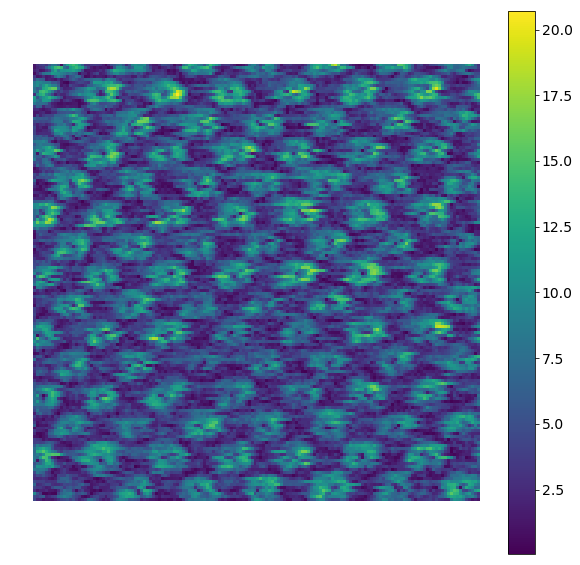

In [10]:
fig = plt.figure(figsize=(10,10))
plt.imshow(COM_exp_mag[2:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

(-0.5, 149.5, 146.5, -0.5)

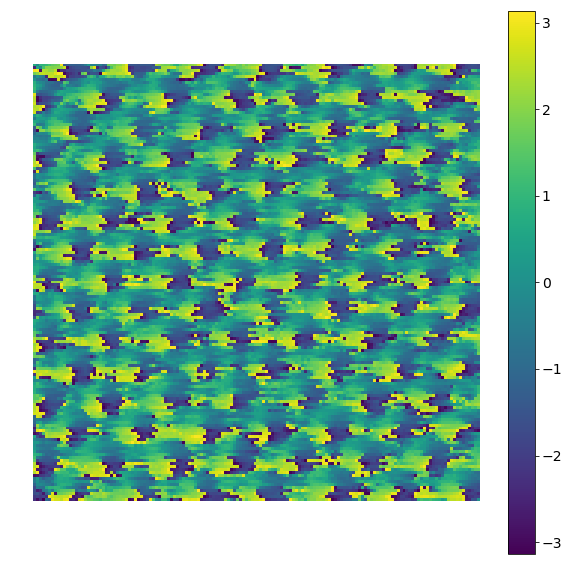

In [9]:
fig = plt.figure(figsize=(10,10))
plt.imshow(COM_exp_ang[2:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

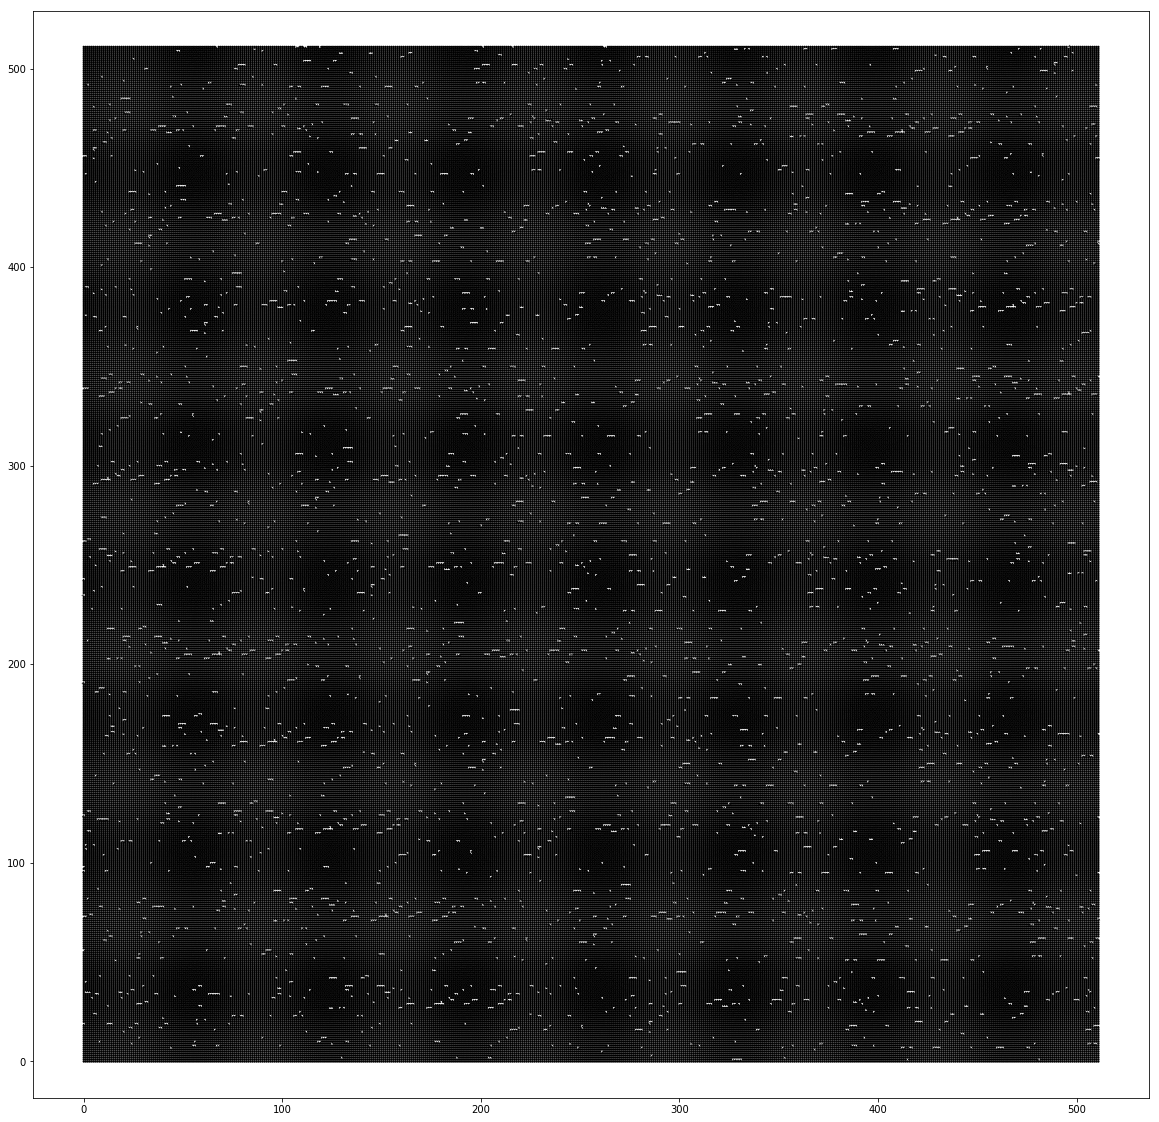

In [27]:


fig = plt.figure(figsize=(20,20))
Q = plt.quiver(weights_x, weights_y, COM_exp[:,:,0], COM_exp[:,:,1])
plt.axis('equal')
# plt.xlim(15, 30)
# plt.ylim(0, 20)

plt.show()

## 121719 Prepare data for Barnaby Levin's paper

Text(0.5, 1.0, 'COM magnitute')

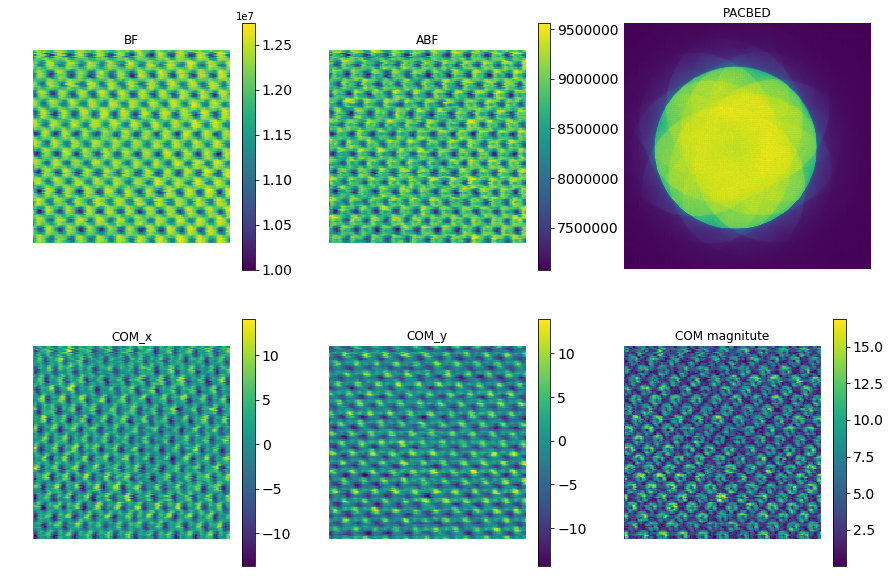

In [2]:
path = '/srv/home/chenyu/DEbackup/061219/S8/'
BF = np.load(path + 'BF.npy')
ABF = np.load(path + 'ABF.npy')
COM = np.load(path+ 'COM.npy')
PACBED = np.load(path + 'PACBED.npy')
COM_mag = np.sqrt(COM[:,:,0]**2 + COM[:,:,1]**2)

fig = plt.figure(figsize=(15,10))

fig.add_subplot(2,3,1)
plt.imshow(BF[2:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('BF')

fig.add_subplot(2,3,2)
plt.imshow(ABF[2:-1:,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('ABF')

fig.add_subplot(2,3,3)
plt.imshow(PACBED)
plt.axis('off')
plt.title('PACBED')

fig.add_subplot(2,3,4)
plt.imshow(COM[2:-1,:,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_x')

fig.add_subplot(2,3,5)
plt.imshow(COM[2:-1:,:,1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_y')

fig.add_subplot(2,3,6)
plt.imshow(COM_mag[2:-1,:])
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.title('COM magnitute')

In [82]:
import scipy.misc
BF_norm = BF[1:-1,1:-1]/np.amax(BF[1:-1,1:-1])*255
ABF_norm = ABF[1:-1,1:-1]/np.amax(ABF[1:-1,1:-1])*255
ADF_norm = ADF[1:-1,1:-1]/np.amax(ADF[1:-1,1:-1])*255

scipy.misc.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/BF.tiff',BF_norm)
scipy.misc.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/ABF.tiff',ABF_norm)
scipy.misc.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/ADF.tiff',ADF_norm)
# scipy.misc.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/COM_magnitute.tiff',COM_mag)
plt.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/COM_magnitute.tiff',COM_mag)

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


In [85]:
# plt.imshow(frame)
CBED_norm = frame/np.amax(frame)*255*255
CBED_norm[CBED_norm<0] = 0
plt.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/CBED_sqrt.tiff',CBED_norm,cmap='hot')

In [79]:
PACBED_norm = PACBED_norm
PACBED_norm[PACBED_norm<0] = 0
PACBED_norm = np.sqrt(PACBED_norm)
PACBED_norm = PACBED/np.amax(PACBED)*255*255
# scipy.misc.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/PACBED_sqrt.tiff',PACBED_norm,cmap='hot')
plt.imsave('/srv/home/chenyu/Service/121719_Banaby_4DSTEM/PACBED_sqrt.tiff',PACBED_norm,cmap='hot')

In [ ]:
imageio.imwrite